In [1]:
!pip install ipywidgets --upgrade
!pip install seaborn --upgrade
!pip install memory_profiler

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import copy
import folium
import re
from statistics import mean, stdev
import pyeasyga.pyeasyga as pyeasyga
from pyeasyga.pyeasyga import GeneticAlgorithm
import itertools
import time
from tqdm import tqdm
import seaborn as sns
from memory_profiler import memory_usage
import psutil
import os

In [6]:
#CARGA DE DATOS
#Se reutiliza el código de carga de datos del proyecto anterior

def load_distance_time_dic(path):
    data = pd.read_csv(path)
    distance = {}
    time = {}
    for i in range(len(data)):
        origen = int(data.iloc[i, 0])
        destino = int(data.iloc[i, 1])
        distance[origen, destino] = float(data.iloc[i, 2])/1000
        time[origen, destino] = float(data.iloc[i, 3])
    return distance, time
5
def load_vehicles(path):
    data = pd.read_csv(path)
    vehicles = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 0])
        capacity = int(data.iloc[i, 1])
        ran = float(data.iloc[i, 2])
        vehicles[id] = (capacity, ran)
    return vehicles

def load_demand(path):
    data = pd.read_csv(path)
    demand_dic = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 1])
        demand = float(data.iloc[i, 2])
        demand_dic[id] = demand
    return demand_dic

def load_coordinates(depotsPath, clientsPath):
    coord = {}
    depot = pd.read_csv(depotsPath)
    client = pd.read_csv(clientsPath)
    for i in range(len(depot)):
        id = int(depot.iloc[i, 1])
        lat = float(depot.iloc[i, 3])
        long = float(depot.iloc[i, 2])
        coord[id] = [lat, long]
    for j in range(len(client)):
        id = int(client.iloc[j, 1])
        lat = float(client.iloc[j, 4])
        long = float(client.iloc[j, 3])
        coord[id] = [lat, long]
    return coord


In [7]:
distancia,time_dic = load_distance_time_dic('../Datos/casoBase.csv')
vehiculos = load_vehicles('../Datos/vehicles.csv')
demanda = load_demand('../Datos/clients.csv')
coord = load_coordinates('../Datos/depots.csv', '../Datos/clients.csv')
print(f"Distancia: {distancia}")
print(f"Vehiculos: {vehiculos}")
print(f"Demanda: {demanda}")
print(f"Coordenadas: {coord}")
print(f"Time: {time_dic}")



Distancia: {(1, 2): 27.144299999999998, (1, 3): 17.6771, (1, 4): 13.9796, (1, 5): 26.6508, (1, 6): 22.5837, (1, 7): 18.5625, (1, 8): 24.765900000000002, (1, 9): 23.9294, (1, 10): 27.835900000000002, (1, 11): 33.6518, (1, 12): 31.029400000000003, (1, 13): 16.1247, (1, 14): 21.6122, (1, 15): 10.3874, (1, 16): 27.040200000000002, (1, 17): 33.9631, (1, 18): 26.5413, (1, 19): 20.0532, (1, 20): 21.278200000000002, (1, 21): 13.411200000000001, (1, 22): 27.8695, (1, 23): 24.2626, (1, 24): 11.364799999999999, (1, 25): 30.8098, (2, 1): 30.809900000000003, (2, 3): 14.2563, (2, 4): 19.400299999999998, (2, 5): 1.1309, (2, 6): 12.475100000000001, (2, 7): 11.4167, (2, 8): 16.8514, (2, 9): 13.820799999999998, (2, 10): 7.5098, (2, 11): 7.110399999999999, (2, 12): 10.8902, (2, 13): 24.4451, (2, 14): 7.9738999999999995, (2, 15): 20.1425, (2, 16): 1.2554, (2, 17): 7.4218, (2, 18): 4.283399999999999, (2, 19): 9.819600000000001, (2, 20): 15.2813, (2, 21): 23.0465, (2, 22): 21.1477, (2, 23): 5.482, (2, 24): 

In [8]:
depot_id = 1  # depósito con demanda 0
pf = 15000
ft = 5000
cm = 700
gv = 0.411458

class VRPGeneticAlgorithm:
    def __init__(self, distance, demand, vehicles, coord):
        self.distance = distance
        self.demand = demand
        self.vehicles = vehicles
        self.coord = coord
        self.clientes = [c for c in demand.keys() if c != depot_id]
        self.demand[depot_id] = 0
        
    def create_individual(self, data):
        """Crear un individuo (conjunto de rutas)"""
        n_vehiculos = len(self.vehicles)
        rutas = [[] for _ in range(n_vehiculos)]
        clientes_copy = self.clientes[:]
        random.shuffle(clientes_copy)
        
        # Asignar cada cliente exactamente a un vehículo (round robin)
        for idx, cliente in enumerate(clientes_copy):
            v_id = idx % n_vehiculos
            rutas[v_id].append(cliente)
        
        # Agregar depósito al inicio y fin de cada ruta
        rutas = [[depot_id] + ruta + [depot_id] if ruta else [] for ruta in rutas]
        return rutas

    def mutate_individual(self, individual, data=None):
        """Mutación: mover un cliente de un vehículo a otro"""
        nuevas_rutas = copy.deepcopy(individual)
        
        # Encontrar vehículos con rutas no vacías
        vehiculos_con_rutas = [i for i, ruta in enumerate(nuevas_rutas) if len(ruta) > 2]
        
        if len(vehiculos_con_rutas) < 2:
            return nuevas_rutas
        
        # Elegir dos vehículos distintos
        v1, v2 = random.sample(vehiculos_con_rutas, 2)
        
        if len(nuevas_rutas[v1]) > 2:
            # Seleccionar cliente aleatorio (excluyendo depósitos)
            cliente = random.choice(nuevas_rutas[v1][1:-1])
            nuevas_rutas[v1].remove(cliente)
            
            # Insertar cliente en posición aleatoria en v2
            if len(nuevas_rutas[v2]) == 0:
                nuevas_rutas[v2] = [depot_id, cliente, depot_id]
            else:
                pos = random.randint(1, len(nuevas_rutas[v2]) - 1)
                nuevas_rutas[v2].insert(pos, cliente)
        
        return nuevas_rutas

    def crossover_individuals(self, parent1, parent2, data=None):
        """Cruzamiento: intercambiar segmentos de rutas entre padres"""
        hijo1 = copy.deepcopy(parent1)
        hijo2 = copy.deepcopy(parent2)
        
        # Seleccionar vehículo aleatorio para cruzar
        v = random.randint(0, len(parent1) - 1)
        
        if len(parent1[v]) > 2 and len(parent2[v]) > 2:
            # Extraer rutas sin depósitos
            ruta1 = parent1[v][1:-1]
            ruta2 = parent2[v][1:-1]
            
            if ruta1 and ruta2:
                # Punto de cruce
                split1 = random.randint(0, len(ruta1))
                split2 = random.randint(0, len(ruta2))
                
                # Crear nuevas rutas cruzadas
                nueva_ruta1 = ruta1[:split1] + ruta2[split2:]
                nueva_ruta2 = ruta2[:split2] + ruta1[split1:]
                
                # Reconstruir rutas con depósitos
                hijo1[v] = [depot_id] + nueva_ruta1 + [depot_id] if nueva_ruta1 else []
                hijo2[v] = [depot_id] + nueva_ruta2 + [depot_id] if nueva_ruta2 else []
                
                # Limpiar duplicados y reasignar clientes faltantes
                hijo1 = self._reparar_solucion(hijo1)
                hijo2 = self._reparar_solucion(hijo2)
        
        return hijo1, hijo2

    def _reparar_solucion(self, rutas):
        """Reparar solución eliminando duplicados y asignando clientes faltantes"""
        # Encontrar todos los clientes asignados
        asignados = set()
        for ruta in rutas:
            for cliente in ruta:
                if cliente != depot_id:
                    asignados.add(cliente)
        
        # Eliminar duplicados
        rutas_limpias = []
        clientes_vistos = set()
        
        for ruta in rutas:
            nueva_ruta = [depot_id]
            for cliente in ruta[1:-1]:  # Excluir depósitos
                if cliente not in clientes_vistos:
                    nueva_ruta.append(cliente)
                    clientes_vistos.add(cliente)
            if len(nueva_ruta) > 1:
                nueva_ruta.append(depot_id)
                rutas_limpias.append(nueva_ruta)
            else:
                rutas_limpias.append([])
        
        # Asignar clientes faltantes
        faltantes = set(self.clientes) - clientes_vistos
        for cliente in faltantes:
            v_id = random.randint(0, len(rutas_limpias) - 1)
            if len(rutas_limpias[v_id]) == 0:
                rutas_limpias[v_id] = [depot_id, cliente, depot_id]
            else:
                rutas_limpias[v_id].insert(-1, cliente)
        
        return rutas_limpias

    def fitness_individual(self, individual, data):
        """Evaluar fitness de un individuo (menor es mejor)"""
        claves_vehiculos = list(self.vehicles.keys())
        total_cost = 0
        
        for v_id, ruta in enumerate(individual):
            if len(ruta) <= 2:  # Ruta vacía
                continue
                
            cap_max, rango_max = self.vehicles[claves_vehiculos[v_id]]
            carga = 0
            distancia_total = 0
            
            # Calcular distancia y carga de la ruta
            for i in range(len(ruta) - 1):
                a, b = ruta[i], ruta[i + 1]
                distancia_total += self.distance.get((a, b), 9999999)
                if b != depot_id:
                    carga += self.demand.get(b, 0)
            
            # Calcular penalizaciones por violación de restricciones
            penalizacion = 0
            if carga > cap_max:
                penalizacion += 1e6 * (carga - cap_max)
            if distancia_total > rango_max:
                penalizacion += 1e6 * (distancia_total - rango_max)
            
            # Costo total del vehículo
            costo_vehiculo = gv * pf * distancia_total + ft + cm + penalizacion
            total_cost += costo_vehiculo
        
        # pyeasyga maximiza fitness, por lo que devolvemos el negativo del costo
        return -total_cost

    def tournament_selection(self, population, tournament_size=3):
        """Selección por torneo"""
        def tournament_select():
            # Seleccionar individuos aleatorios para el torneo
            tournament = random.sample(population, min(tournament_size, len(population)))
            # Devolver el mejor individuo del torneo
            return max(tournament, key=lambda x: x.fitness)
        
        return tournament_select

    def _verificar_asignacion_completa(self, rutas):
        """Verificar que todos los clientes estén asignados"""
        asignados = set()
        for ruta in rutas:
            for cliente in ruta:
                if cliente != depot_id:
                    asignados.add(cliente)
        
        faltantes = set(self.clientes) - asignados
        return faltantes


def run_ga_pyeasyga(distance, demand, vehicles, coord, 
                            n_generaciones=200, n_poblacion=50, 
                            prob_mutacion=0.2, prob_cruzamiento=0.8,
                            elitismo=5, tournament_size=3):
    """
    Versión mejorada del algoritmo genético con pyeasyga
    """
    # Crear instancia del problema VRP con verificaciones extendidas
    vrp = VRPGeneticAlgorithm(distance, demand, vehicles, coord)
    
    # Configurar algoritmo genético
    ga = GeneticAlgorithm(
        seed_data=None,
        population_size=n_poblacion,
        generations=n_generaciones,
        crossover_probability=prob_cruzamiento,
        mutation_probability=prob_mutacion,
        elitism=True,
        maximise_fitness=True
    )
    
    # Asignar funciones personalizadas
    ga.create_individual = vrp.create_individual
    ga.mutate_function = vrp.mutate_individual
    ga.crossover_function = vrp.crossover_individuals
    ga.fitness_function = vrp.fitness_individual
    
    fitness_history = []

    # Sobrescribir el método rank_population para guardar el mejor fitness
    original_rank_population = ga.rank_population
    def rank_and_record():
        original_rank_population()
        # El mejor fitness está en la primera posición después de ordenar
        fitness_history.append(ga.current_generation[0].fitness)
    ga.rank_population = rank_and_record
    
    # Ejecutar algoritmo genético
    print("Iniciando algoritmo genético mejorado...")
    ga.run()
    
    # Obtener mejor solución
    mejor_solucion = ga.best_individual()[1]
    mejor_fitness = -ga.best_individual()[0]
    
    # Verificaciones finales
    faltantes = vrp._verificar_asignacion_completa(mejor_solucion)
    if faltantes:
        print(f"¡Atención! Algunos nodos no fueron asignados: {faltantes}")
    else:
        print("Todos los nodos fueron asignados correctamente.")
    
    print(f"Mejor costo: {mejor_fitness}")
    
    # Obtener historial de fitness
    fitness_history = [-fitness for fitness in fitness_history]
    
    return mejor_solucion, fitness_history

In [11]:
def visualizar_rutas_folium(rutas, coord):
    # Crear mapa centrado en depósito o promedio de coordenadas
    lat_dep, lon_dep = coord[depot_id]
    m = folium.Map(location=[lat_dep, lon_dep], zoom_start=11, tiles='Cartodb Positron')

    colors = ['blue', 'green', 'cyan', 'magenta','olive', 'blue', 'orange', 'purple','red']
    icons = ['blue', 'green', 'lightblue', 'pink','lightgreen', 'blue', 'orange', 'darkpurple','red']

    for v, ruta in enumerate(rutas):
        if not ruta or len(ruta) < 2:
            continue

        # Construir lista de coordenadas para PolyLine: [(lat, lon), (lat, lon), ...]
        coords_ruta = [coord[n] for n in ruta]

        # Dibujar la ruta
        folium.PolyLine(
            coords_ruta,
            color=colors[v % len(colors)],
            weight=5,
            opacity=0.7,
            tooltip=f'Vehículo {v}'
        ).add_to(m)

        # Marcador inicio (depósito)
        folium.Marker(
            coords_ruta[0],
            popup="Inicio (Depósito)",
            icon=folium.Icon(color='black', icon='home')
        ).add_to(m)

        # Marcador fin de ruta
        folium.Marker(
            coords_ruta[-1],
            popup=f"Llegada Vehículo {v}",
            icon=folium.Icon(color=icons[v % len(icons)], icon='flag')
        ).add_to(m)

    return m


In [ ]:
# Medir memoria antes
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / 1024**2  # en MiB

# Ejecutar tu función normalmente
solucion, evol = run_ga_pyeasyga(distancia, demanda, vehiculos, coord, n_generaciones=300)

# Medir memoria después
mem_after = process.memory_info().rss / 1024**2  # en MiB

print(f"Memoria antes: {mem_before:.2f} MiB")
print(f"Memoria después: {mem_after:.2f} MiB")
print(f"Diferencia de memoria: {mem_after - mem_before:.2f} MiB")

mapa = visualizar_rutas_folium(solucion, coord)
mapa

Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 2078110.4755619997
Memoria antes: 193.66 MiB
Memoria después: 193.66 MiB
Diferencia de memoria: 0.00 MiB


## Visualización y estadísticas

In [10]:

def isClient(name):
    return bool(re.fullmatch(r'C\d+', name))

#SIN TERMINAR
def generateValidationFile(rutas, vehiculos, clientes):
    data = {
    'VehicleId':[] ,
    'DepotId':[] ,
    'InitialLoad':[] ,
    'RouteSequence':[] ,
    'ClientsServed':[] ,
    'DemandsSatisfied':[] , 
    'TotalDistance':[] , 
    'TotalTime':[] , 
    'FuelCost':[]
    }
    for ruta in rutas:
        print('r', ruta)
    for v in vehiculos:
        path = []
    
        print('v', v)
        data['VehicleId'].append("VEH" + "{:03d}".format(v))
        clients = 0
        demandas = []
        total_demand = 0
        for nodo in rutas[v-1]:
            if nodo == 1:
                path.append('CD1')
            else:
                path.append('C' + str(nodo))
                clients += 1
                demanda_c = demanda[nodo]
                print(demanda_c)
                demandas.append(str(demanda_c))
                total_demand += demanda_c
        print(demandas)
        data['RouteSequence'].append("-".join(path))
        data['ClientsServed'].append(clients)
        data['DepotId'].append('CD1')
        data['DemandsSatisfied'].append("-".join(demandas))
        data['InitialLoad'].append(total_demand)

        
        total_dist = 0
        t_time = 0
        ruta = rutas[v-1]
        for i in range(len(ruta) -1):
            total_dist += distancia[(ruta[i],ruta[i+1])]
            t_time += time_dic[(ruta[i],ruta[i+1])]
        t_time = t_time/60
        print(total_dist)
        print(t_time)



        data['TotalDistance'].append(round(total_dist,1))
        data['TotalTime'].append(round(t_time, 1))
        data['FuelCost'].append(round((total_dist)*pf))
        #print("time", t_time)

    print(data)
    df = pd.DataFrame(data)
    df.to_csv("verificacion_casoBase_metaheuristica_1.csv", index=False)
    
generateValidationFile(solucion, vehiculos, demanda)   

#print(data)

r [1, 16, 12, 10, 19, 7, 3, 13, 1]
r [1, 8, 20, 22, 4, 1]
r []
r []
r []
r []
r [1, 2, 17, 6, 9, 24, 15, 21, 1]
r [1, 14, 11, 25, 5, 23, 18, 1]
v 1
17.0
17.0
20.0
12.0
17.0
15.0
12.0
['17.0', '17.0', '20.0', '12.0', '17.0', '15.0', '12.0']
95.26350000000002
140.85
v 2
17.0
11.0
14.0
12.0
['17.0', '11.0', '14.0', '12.0']
65.4902
99.47333333333334
v 3
[]
0
0.0
v 4
[]
0
0.0
v 5
[]
0
0.0
v 6
[]
0
0.0
v 7
13.0
10.0
20.0
20.0
15.0
15.0
15.0
['13.0', '10.0', '20.0', '20.0', '15.0', '15.0', '15.0']
86.90769999999999
138.41333333333333
v 8
21.0
15.0
11.0
15.0
18.0
25.0
['21.0', '15.0', '11.0', '15.0', '18.0', '25.0']
86.18520000000001
133.27
{'VehicleId': ['VEH001', 'VEH002', 'VEH003', 'VEH004', 'VEH005', 'VEH006', 'VEH007', 'VEH008'], 'DepotId': ['CD1', 'CD1', 'CD1', 'CD1', 'CD1', 'CD1', 'CD1', 'CD1'], 'InitialLoad': [110.0, 54.0, 0, 0, 0, 0, 108.0, 105.0], 'RouteSequence': ['CD1-C16-C12-C10-C19-C7-C3-C13-CD1', 'CD1-C8-C20-C22-C4-CD1', '', '', '', '', 'CD1-C2-C17-C6-C9-C24-C15-C21-CD1', 'CD1-C

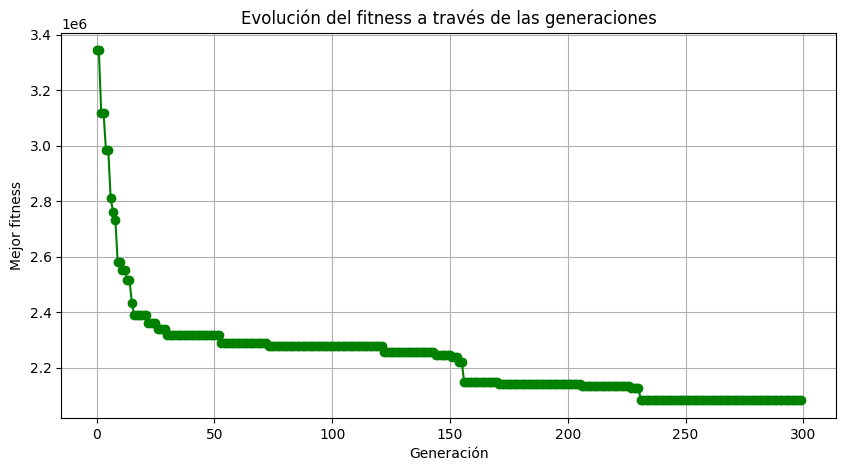

Costo total: 2106057.815142
Costo promedio por vehículo: 263257.22689275
Desviación estándar de costos: 261970.65217756273


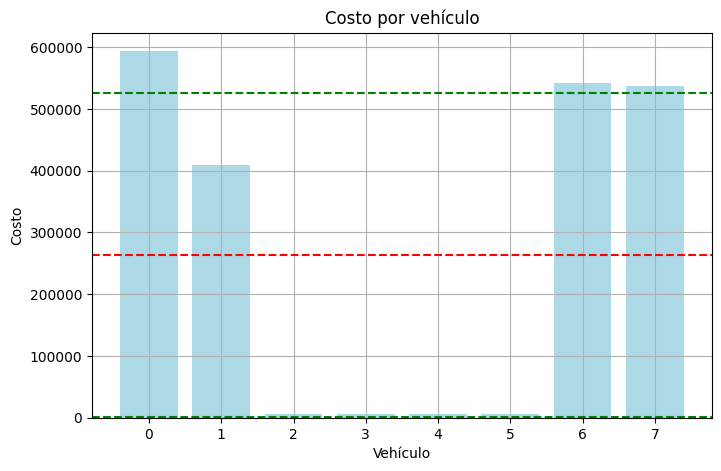

In [11]:

def graficar_costos_por_vehiculo(rutas, distancia, pf, ft, cm, gv):
    costos =[]
    for ruta in rutas:
        distance = 0
        for i in range(len(ruta)-1):
            distance += distancia[(ruta[i], ruta[i+1])]
        costo = gv*pf * distance + ft + cm
        costos.append(costo)
    media =  np.mean(costos)
    dev_est = np.std(costos) 
    print("Costo total:", sum(costos))
    print("Costo promedio por vehículo:", media)
    print("Desviación estándar de costos:", dev_est)

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(costos)), costos, color='lightblue')
    plt.axhline(y=media, color='r', linestyle='dashed')
    plt.axhline(y=media+dev_est, color='g', linestyle='dashed')
    plt.axhline(y=media-dev_est, color='g', linestyle='dashed')
    plt.xlabel('Vehículo')
    plt.ylabel('Costo')
    plt.title('Costo por vehículo')
    plt.grid(True)
    plt.show()


def graficar_evolucion_fitness(mejores_costos):
    plt.figure(figsize=(10, 5))
    plt.plot(mejores_costos, marker='o', color='green')
    plt.xlabel('Generación')
    plt.ylabel('Mejor fitness')
    plt.title('Evolución del fitness a través de las generaciones')
    plt.grid(True)
    plt.show()

graficar_evolucion_fitness(evol)
graficar_costos_por_vehiculo(solucion, distancia, pf, ft, cm, gv)


Al evidenciar que el modelo da una solución factible, se procede a diseñar los experimeintos para calibrar de la mejor manera nuestro algoritmo. Para esto vamos a variar los parámetros de 3 maneras para poder comparar resultados. Se proponen las siguientes pruebas


| #  | n_generaciones | n_poblacion | prob_mutacion | prob_cruzamiento | elitismo | tournament_size |
|----|----------------|-------------|----------------|-------------------|----------|------------------|
| 1  | 100            | 50          | 0.1            | 0.6               | True     | 3                |
| 2  | 100            | 50          | 0.1            | 0.6               | True     | 5                |
| 3  | 100            | 50          | 0.1            | 0.8               | True     | 3                |
| 4  | 100            | 50          | 0.1            | 0.8               | True     | 5                |
| 5  | 100            | 50          | 0.3            | 0.6               | True     | 3                |
| 6  | 100            | 50          | 0.3            | 0.6               | True     | 5                |
| 7  | 100            | 50          | 0.3            | 0.8               | True     | 3                |
| 8  | 100            | 50          | 0.3            | 0.8               | True     | 5                |
| 9  | 100            | 70          | 0.1            | 0.6               | True     | 3                |
| 10 | 100            | 70          | 0.1            | 0.6               | True     | 5                |
| 11 | 100            | 70          | 0.1            | 0.8               | True     | 3                |
| 12 | 100            | 70          | 0.1            | 0.8               | True     | 5                |
| 13 | 100            | 70          | 0.3            | 0.6               | True     | 3                |
| 14 | 100            | 70          | 0.3            | 0.6               | True     | 5                |
| 15 | 100            | 70          | 0.3            | 0.8               | True     | 3                |
| 16 | 100            | 70          | 0.3            | 0.8               | True     | 5                |
| 17 | 200            | 50          | 0.1            | 0.6               | True     | 3                |
| 18 | 200            | 50          | 0.1            | 0.6               | True     | 5                |
| 19 | 200            | 50          | 0.1            | 0.8               | True     | 3                |
| 20 | 200            | 50          | 0.1            | 0.8               | True     | 5                |
| 21 | 200            | 50          | 0.3            | 0.6               | True     | 3                |
| 22 | 200            | 50          | 0.3            | 0.6               | True     | 5                |
| 23 | 200            | 50          | 0.3            | 0.8               | True     | 3                |
| 24 | 200            | 50          | 0.3            | 0.8               | True     | 5                |
| 25 | 200            | 70          | 0.1            | 0.6               | True     | 3                |
| 26 | 200            | 70          | 0.1            | 0.6               | True     | 5                |
| 27 | 200            | 70          | 0.1            | 0.8               | True     | 3                |
| 28 | 200            | 70          | 0.1            | 0.8               | True     | 5                |
| 29 | 200            | 70          | 0.3            | 0.6               | True     | 3                |
| 30 | 200            | 70          | 0.3            | 0.6               | True     | 5                |
| 31 | 200            | 70          | 0.3            | 0.8               | True     | 3                |
| 32 | 200            | 70          | 0.3            | 0.8               | True     | 5                |
| 33 | 300            | 50          | 0.1            | 0.6               | True     | 3                |
| 34 | 300            | 50          | 0.1            | 0.6               | True     | 5                |
| 35 | 300            | 50          | 0.1            | 0.8               | True     | 3                |
| 36 | 300            | 50          | 0.1            | 0.8               | True     | 5                |
| 37 | 300            | 50          | 0.3            | 0.6               | True     | 3                |
| 38 | 300            | 50          | 0.3            | 0.6               | True     | 5                |
| 39 | 300            | 50          | 0.3            | 0.8               | True     | 3                |
| 40 | 300            | 50          | 0.3            | 0.8               | True     | 5                |
| 41 | 300            | 70          | 0.1            | 0.6               | True     | 3                |
| 42 | 300            | 70          | 0.1            | 0.6               | True     | 5                |
| 43 | 300            | 70          | 0.1            | 0.8               | True     | 3                |
| 44 | 300            | 70          | 0.1            | 0.8               | True     | 5                |
| 45 | 300            | 70          | 0.3            | 0.6               | True     | 3                |
| 46 | 300            | 70          | 0.3            | 0.6               | True     | 5                |
| 47 | 300            | 70          | 0.3            | 0.8               | True     | 3                |
| 48 | 300            | 70          | 0.3            | 0.8               | True     | 5                |


In [ ]:
def experimento_ga(distance, demand, vehicles, coord, 
                   param_grid, repeticiones=3):
    
    resultados = []

    # Crear todas las combinaciones posibles de parámetros
    keys, values = zip(*param_grid.items())
    combinaciones = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for config in tqdm(combinaciones, desc="Configuraciones"):
        costos = []
        tiempos = []
        for r in range(repeticiones):
            seed = 42 + r  # Semilla diferente por repetición
            random.seed(seed)

            start_time = time.process_time()
            solucion, historial = run_ga_pyeasyga(
                distance=distance,
                demand=demand,
                vehicles=vehicles,
                coord=coord,
                n_generaciones=config['n_generaciones'],
                n_poblacion=config['n_poblacion'],
                prob_mutacion=config['prob_mutacion'],
                prob_cruzamiento=config['prob_cruzamiento'],
                elitismo=config['elitismo'],
                tournament_size=config['tournament_size']
            )
            mem_usage, (solucion, historial) = memory_usage(run_ga_pyeasyga, retval=True, max_usage=True, interval=0.1)
            max_mem = max(mem_usage)
            end_time = time.process_time()
            tiempo_cpu = end_time - start_time
            
            # Valor de la función objetivo (último valor en historial)
            costo_final = historial[-1]
            costos.append(costo_final)
            tiempos.append(tiempo_cpu)

        
        resultados.append({
            **config,
            "mejor": np.min(costos),
            "peor": np.max(costos),
            "promedio": np.mean(costos),
            "std": np.std(costos),
            "tiempo_prom": np.mean(tiempos),
        })
    
    df_resultados = pd.DataFrame(resultados)
    return df_resultados


In [ ]:
param_grid = {
    "n_generaciones": [100, 200,300],
    "n_poblacion": [50,70],
    "prob_mutacion": [0.1,0.3],
    "prob_cruzamiento": [0.6,0.8],
    "elitismo": [True],
    "tournament_size": [3,5]
}

# Ejecutar el experimento
df_resultados = experimento_ga(distancia, demanda, vehiculos, coord, param_grid, repeticiones=3)

# Mostrar resultados ordenados por mejor promedio
df_resultados.sort_values("promedio").head()

Configuraciones:   0%|          | 0/48 [00:00<?, ?it/s]

Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 2418453.309216


Las gráficas fueron realizadas con ayuda de la IA generativa Claude en su modelo Sonnet 4 bajo el prompt: quiero una gráfica que me permita ver 
registrar el tiempo de CPU y compararlo con la  valor de la función objetivo, 
mejor, peor, media, desviación estándar

In [13]:
def grafico_tiempo_cpu_parametros(df_resultados):
    """
    Crea una gráfica que muestra la relación entre tiempo de CPU y parámetros del GA
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análisis de Tiempo de CPU vs Parámetros del Algoritmo Genético', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # Colores consistentes para cada configuración
    colors = plt.cm.Set3(np.linspace(0, 1, len(df_resultados)))
    
    # 1. Tiempo CPU vs Número de Generaciones
    ax1.scatter(df_resultados['n_generaciones'], df_resultados['tiempo_prom'], 
               s=100, c=colors, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Línea de tendencia
    z = np.polyfit(df_resultados['n_generaciones'], df_resultados['tiempo_prom'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_resultados['n_generaciones'].min(), 
                         df_resultados['n_generaciones'].max(), 100)
    ax1.plot(x_trend, p(x_trend), "--", color='red', alpha=0.8, linewidth=2)
    
    ax1.set_xlabel('Número de Generaciones', fontsize=12)
    ax1.set_ylabel('Tiempo CPU Promedio (s)', fontsize=12)
    ax1.set_title('Tiempo vs Generaciones', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Correlación
    corr_gen = df_resultados['n_generaciones'].corr(df_resultados['tiempo_prom'])
    ax1.text(0.05, 0.95, f'Correlación: {corr_gen:.3f}', 
             transform=ax1.transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # 2. Tiempo CPU vs Tamaño de Población
    ax2.scatter(df_resultados['n_poblacion'], df_resultados['tiempo_prom'], 
               s=100, c=colors, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Línea de tendencia
    z = np.polyfit(df_resultados['n_poblacion'], df_resultados['tiempo_prom'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_resultados['n_poblacion'].min(), 
                         df_resultados['n_poblacion'].max(), 100)
    ax2.plot(x_trend, p(x_trend), "--", color='red', alpha=0.8, linewidth=2)
    
    ax2.set_xlabel('Tamaño de Población', fontsize=12)
    ax2.set_ylabel('Tiempo CPU Promedio (s)', fontsize=12)
    ax2.set_title('Tiempo vs Tamaño Población', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Correlación
    corr_pob = df_resultados['n_poblacion'].corr(df_resultados['tiempo_prom'])
    ax2.text(0.05, 0.95, f'Correlación: {corr_pob:.3f}', 
             transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # 3. Heatmap de Tiempo por combinación de parámetros principales
    # Crear tabla pivot para el heatmap
    pivot_data = df_resultados.pivot_table(
        values='tiempo_prom', 
        index='n_generaciones', 
        columns='n_poblacion', 
        aggfunc='mean'
    )
    
    im = ax3.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
    ax3.set_xticks(range(len(pivot_data.columns)))
    ax3.set_yticks(range(len(pivot_data.index)))
    ax3.set_xticklabels(pivot_data.columns)
    ax3.set_yticklabels(pivot_data.index)
    ax3.set_xlabel('Tamaño de Población', fontsize=12)
    ax3.set_ylabel('Número de Generaciones', fontsize=12)
    ax3.set_title('Mapa de Calor: Tiempo CPU', fontsize=14, fontweight='bold')
    
    # Añadir valores en el heatmap
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            if not pd.isna(pivot_data.iloc[i, j]):
                text = ax3.text(j, i, f'{pivot_data.iloc[i, j]:.2f}', 
                               ha="center", va="center", color="black", fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
    cbar.set_label('Tiempo CPU (s)', rotation=270, labelpad=15)
    
    # 4. Gráfico de barras: Tiempo promedio por configuración ordenado
    df_sorted = df_resultados.sort_values('tiempo_prom')
    config_labels = [f"C{i+1}" for i in range(len(df_sorted))]
    
    bars = ax4.bar(range(len(df_sorted)), df_sorted['tiempo_prom'], 
                   color=plt.cm.viridis(np.linspace(0, 1, len(df_sorted))), 
                   alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax4.set_xlabel('Configuraciones (ordenadas por tiempo)', fontsize=12)
    ax4.set_ylabel('Tiempo CPU Promedio (s)', fontsize=12)
    ax4.set_title('Tiempo CPU por Configuración', fontsize=14, fontweight='bold')
    ax4.set_xticks(range(len(df_sorted)))
    ax4.set_xticklabels(config_labels, rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores encima de las barras
    for i, (bar, tiempo) in enumerate(zip(bars, df_sorted['tiempo_prom'])):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{tiempo:.2f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Añadir información de parámetros para las configuraciones más lentas y rápidas
    mas_rapida = df_sorted.iloc[0]
    mas_lenta = df_sorted.iloc[-1]
    
    info_text = f"""
    Configuración más rápida: {mas_rapida['tiempo_prom']:.2f}s
    Gen: {mas_rapida['n_generaciones']}, Pob: {mas_rapida['n_poblacion']}
    
    Configuración más lenta: {mas_lenta['tiempo_prom']:.2f}s  
    Gen: {mas_lenta['n_generaciones']}, Pob: {mas_lenta['n_poblacion']}
    
    Factor de diferencia: {mas_lenta['tiempo_prom']/mas_rapida['tiempo_prom']:.1f}x
    """
    
    ax4.text(0.02, 0.98, info_text, transform=ax4.transAxes, 
             bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8),
             verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir análisis detallado
    print("="*70)
    print("ANÁLISIS DE TIEMPO DE CPU vs PARÁMETROS")
    print("="*70)
    
    print(f"\nTiempo CPU mínimo: {df_resultados['tiempo_prom'].min():.3f}s")
    print(f"Tiempo CPU máximo: {df_resultados['tiempo_prom'].max():.3f}s")
    print(f"Tiempo CPU promedio: {df_resultados['tiempo_prom'].mean():.3f}s")
    print(f"Diferencia máxima: {df_resultados['tiempo_prom'].max()/df_resultados['tiempo_prom'].min():.1f}x")
    
    print(f"\nCorrelación Generaciones-Tiempo: {corr_gen:.3f}")
    print(f"Correlación Población-Tiempo: {corr_pob:.3f}")
    
    # Análisis del impacto de cada parámetro
    print("\nIMPACTO DE PARÁMETROS EN TIEMPO CPU:")
    print("-" * 40)
    
    # Agrupar por cada parámetro y ver el efecto en tiempo
    for param in ['n_generaciones', 'n_poblacion', 'prob_mutacion', 'prob_cruzamiento', 'tournament_size']:
        if param in df_resultados.columns:
            grouped = df_resultados.groupby(param)['tiempo_prom'].agg(['mean', 'std']).round(3)
            print(f"\n{param.replace('_', ' ').title()}:")
            for value, stats in grouped.iterrows():
                print(f"  {value}: {stats['mean']:.3f}s (±{stats['std']:.3f})")
    
    return fig

# Función auxiliar para crear una tabla resumen
def tabla_resumen_tiempo_parametros(df_resultados):
    """
    Crea una tabla resumen del análisis tiempo-parámetros
    """
    print("\n" + "="*80)
    print("TABLA RESUMEN: CONFIGURACIONES ORDENADAS POR TIEMPO CPU")
    print("="*80)
    
    df_sorted = df_resultados.sort_values('tiempo_prom')
    
    print(f"{'Config':<8} {'Gen':<6} {'Pob':<6} {'Mut':<6} {'Cruz':<6} {'Tour':<6} {'Tiempo':<10} {'F.O.Prom':<12}")
    print("-" * 80)
    
    for i, (idx, row) in enumerate(df_sorted.iterrows()):
        print(f"C{i+1:<7} {row['n_generaciones']:<6} {row['n_poblacion']:<6} "
              f"{row['prob_mutacion']:<6.1f} {row['prob_cruzamiento']:<6.1f} "
              f"{row['tournament_size']:<6} {row['tiempo_prom']:<10.3f} {row['promedio']:<12.2f}")

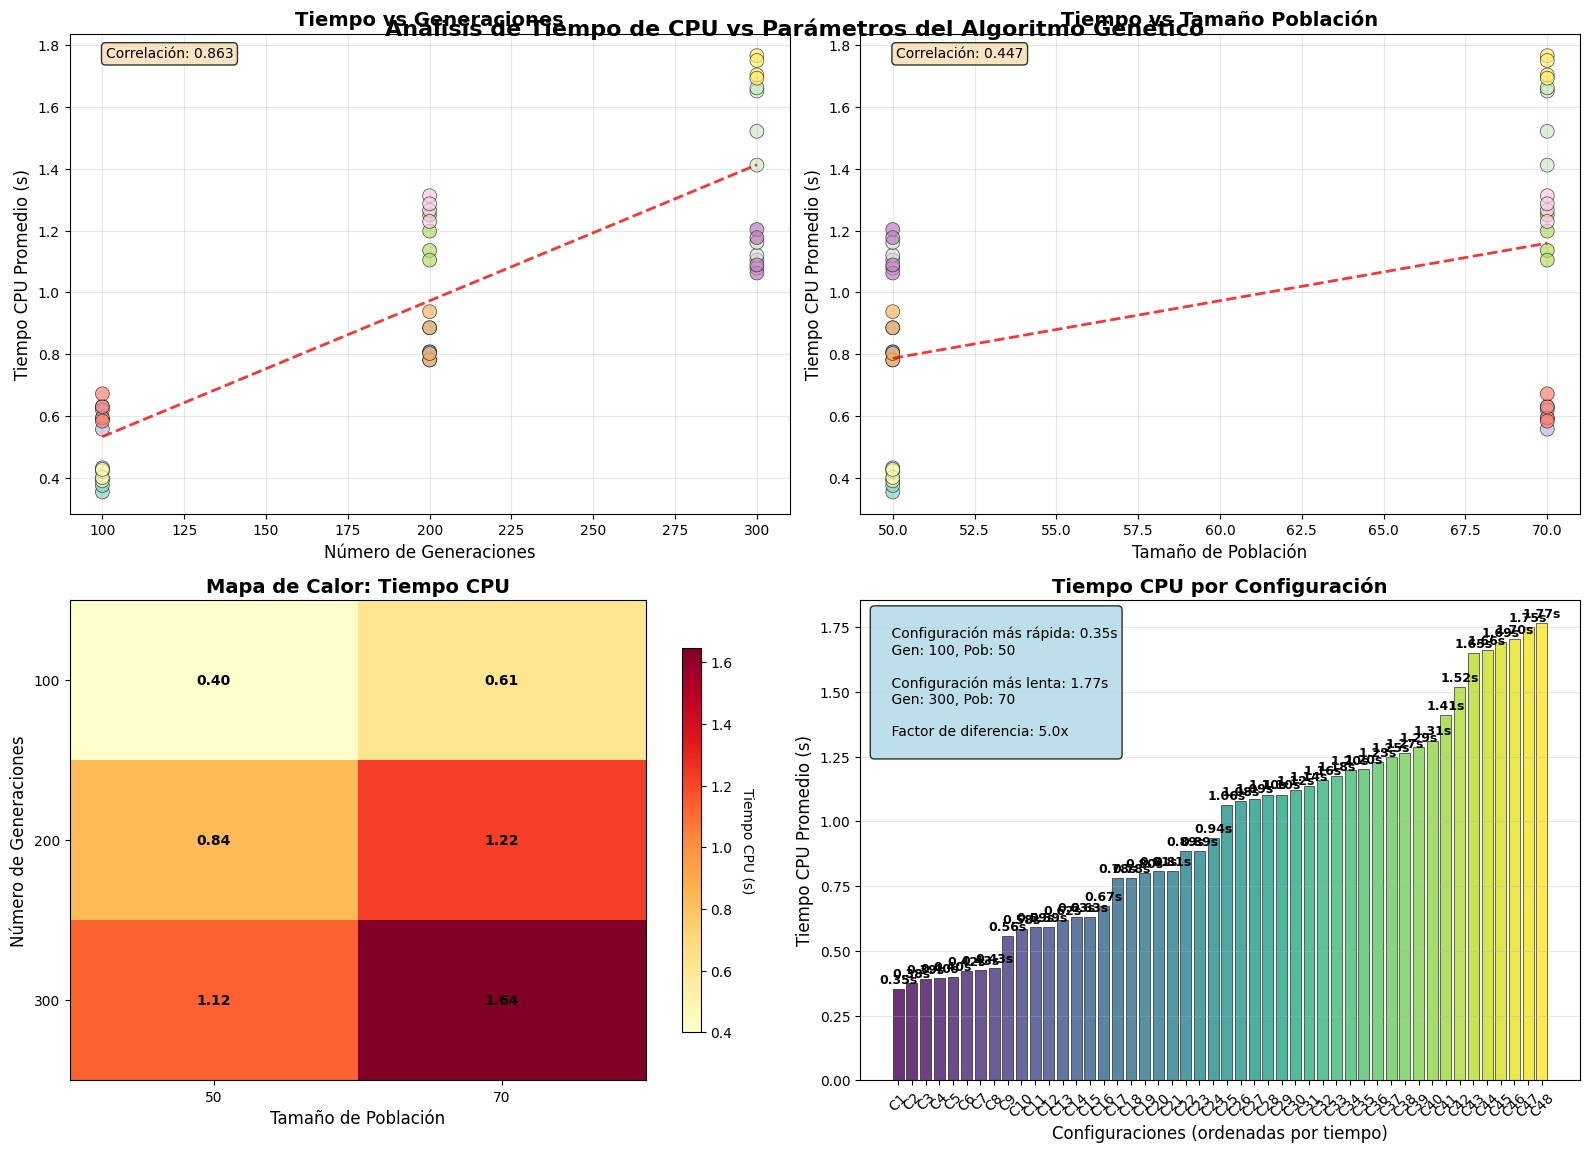

ANÁLISIS DE TIEMPO DE CPU vs PARÁMETROS

Tiempo CPU mínimo: 0.354s
Tiempo CPU máximo: 1.766s
Tiempo CPU promedio: 0.973s
Diferencia máxima: 5.0x

Correlación Generaciones-Tiempo: 0.863
Correlación Población-Tiempo: 0.447

IMPACTO DE PARÁMETROS EN TIEMPO CPU:
----------------------------------------

N Generaciones:
  100: 0.505s (±0.113)
  200: 1.029s (±0.210)
  300: 1.384s (±0.283)

N Poblacion:
  50: 0.787s (±0.308)
  70: 1.159s (±0.441)

Prob Mutacion:
  0.1: 0.943s (±0.400)
  0.3: 1.003s (±0.447)

Prob Cruzamiento:
  0.6: 0.936s (±0.409)
  0.8: 1.010s (±0.437)

Tournament Size:
  3: 0.972s (±0.429)
  5: 0.973s (±0.422)

TABLA RESUMEN: CONFIGURACIONES ORDENADAS POR TIEMPO CPU
Config   Gen    Pob    Mut    Cruz   Tour   Tiempo     F.O.Prom    
--------------------------------------------------------------------------------
C1       100    50     0.1    0.6    3      0.354      2342280.59  
C2       100    50     0.1    0.8    3      0.375      2361383.15  
C3       100    50     0.3 

In [76]:
grafico_tiempo_cpu_parametros(df_resultados)
tabla_resumen_tiempo_parametros(df_resultados)

## Analisis de Escalabilidad

## Comparación son soluciones previas (Pyomo)